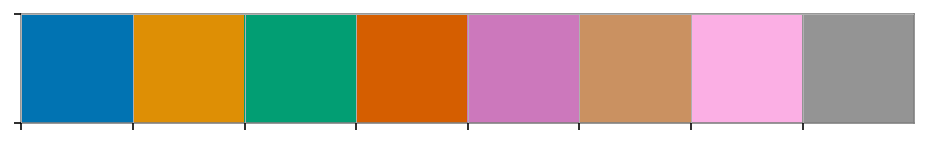

In [32]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
#import matplotlib.pyplot as P

golden_ratio = 1.61803398875
matplotlib.rcParams['figure.figsize'] = (10, 10/golden_ratio)

import gwsurrogate

from tqdm import tqdm

from bilby.core.utils import nfft, infft

from scipy import interpolate
import scipy.integrate as integrate
from scipy import stats
from scipy.signal.windows import tukey
from scipy.stats import truncnorm, norm
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as spline

import lal

import numexpr as ne
#import pyfftw

import seaborn as sns

cp = sns.color_palette('colorblind', 8)
sns.palplot(cp)
plt.show()

from gwtools import gwutils as gwu

In [5]:
sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
trunc_sur = gwsurrogate.LoadSurrogate('/home/carl-johan.haster/projects/Waveform_marginalisation/TruncatedSurrogate/NRHybSur3dq8.h5')

/home/carl-johan.haster/.conda/envs/WF_marg_igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/saveH5Object.py:106: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  v = item.value


Loaded NRHybSur3dq8 model
Loaded NRHybSur3dq8 model


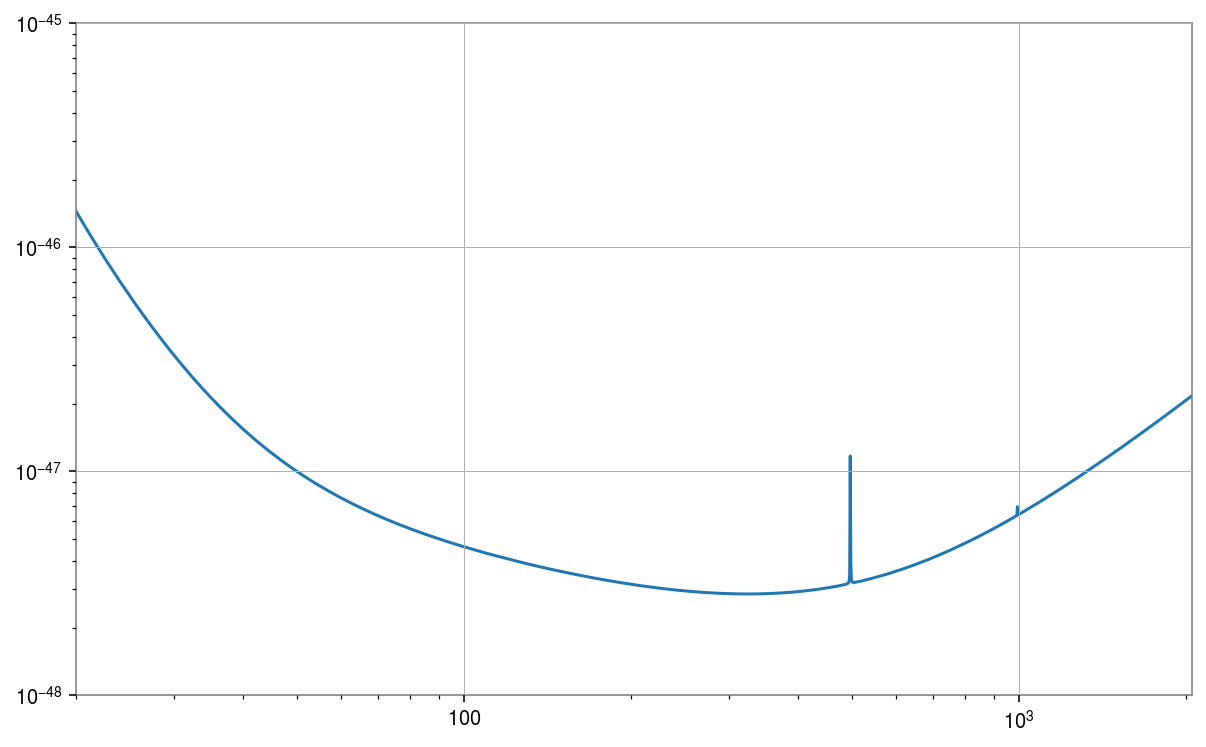

In [33]:
Aplus_asd = np.genfromtxt('/home/carl-johan.haster/projects/Waveform_marginalisation/Injection_data/PSDs/AplusDesign_filledIn.txt')

plt.loglog(Aplus_asd[:,0], np.square(Aplus_asd[:,1]))
plt.xlim(20, 2048)
plt.ylim(1e-48, 1e-45)
plt.show()

In [141]:
def uniform_in_cos_angle(N,costheta_min=-1, costheta_max=1, offset=0.):
    return np.arccos(np.random.uniform(costheta_min,costheta_max,N)) + offset

def uniform_in_angle(N,theta_min=0., theta_max=2.*np.pi, offset=0.):
    return np.random.uniform(theta_min,theta_max,N) + offset

def innprod(h1, h2, freq, Sn):
    #print(h1.shape, h2.shape, freq.shape, Sn.shape)
    over = ne.evaluate('h1*complex(h2.real, -h2.imag)/Sn')
    integral = integrate.simps(over, freq)
    return 4.*integral.real

def spline_interp(newX, oldX, oldY):
    if len(oldY) != len(oldX):
        raise Exception('Lengths dont match.')

    if np.min(newX) < np.min(oldX) or np.max(newX) > np.max(oldX):
        print (newX[0], oldX[0], newX[-1], oldX[-1])
        raise Exception('Trying to extrapolate, disabled for now')

    newY = spline(oldX, oldY, ext=1)(newX)      # returns 0 when extrapolating
    return newY

def spline_interp_ext0(newX, oldX, oldY):
    if len(oldY) != len(oldX):
        raise Exception('Lengths dont match.')

    #if np.min(newX) < np.min(oldX) or np.max(newX) > np.max(oldX):
    #    print (newX[0], oldX[0], newX[-1], oldX[-1])
    #    raise Exception('Trying to extrapolate, disabled for now')

    newY = spline(oldX, oldY, ext='zeros')(newX)      # returns 0 when extrapolating
    return newY

def get_uniform_in_orbits_times(t, phi_orb, PTS_PER_ORBIT=5):
    """
    returns sparse time array such that there are PTS_PER_ORBIT points
    in each orbit.
    """
    # get numer of orbits
    n_orbits = int(abs((phi_orb[-1] - phi_orb[0])/(2*np.pi)))

    # get sparse times such that there are PTS_PER_ORBIT points in each orbit
    n_pts = int(n_orbits*PTS_PER_ORBIT)
    phi_orb_sparse = np.linspace(phi_orb[0], phi_orb[-1], n_pts)
    t_sparse = np.interp(phi_orb_sparse, phi_orb, t)

    return t_sparse

def NRHybSur3dq8_marg(times_from_outside, total_mass, q, chi1, chi2, theta_jn, dist_mpc=400, phi_ref=0,\
                      f_ref=20, f_low=20, sampling_frequency=4096., PointsPerOrbit = 3):

    dt = 1./sampling_frequency
    #dt = times_from_outside[1]-times_from_outside[0]
    ellMax = None

    # evaluate waveform modes for full surrogate
    t, hdict, _ = sur(q, chi1, chi2, dt=dt, f_low=f_low, f_ref=f_ref, ellMax=ellMax, dist_mpc=dist_mpc, M=total_mass, units='mks')
    # project modes following LAL convention
    h = sur._mode_sum(hdict, theta_jn, np.pi/2 - phi_ref, fake_neg_modes=True)
    
    # similarly, evaluate truncated surrogate
    t_trunc, hdict_trunc, _ = trunc_sur(q, chi1, chi2, dt=dt, f_low=f_low, f_ref=f_ref, ellMax=ellMax, dist_mpc=dist_mpc, M=total_mass, units='mks')
    h_trunc = trunc_sur._mode_sum(hdict_trunc, theta_jn, np.pi/2 - phi_ref, fake_neg_modes=True)
    
    # use orbital phase to get sparse times such that there are 5 points per orbit
    # FIXME: This will oversample the post ringdown, so throw those away
    phi_orb = -np.unwrap(np.angle(hdict[(2,2)]))/2
    t_sparse = get_uniform_in_orbits_times(t, phi_orb, PTS_PER_ORBIT=PointsPerOrbit)
    
    
    # interpolate onto a common time array
    # extra caution to avoid extrapolation
    #print(t[1], t_trunc[1], t[-2], t[-2], dt)
    times = np.arange(max(t[1], t_trunc[1]), min(t[-2], t[-2]), dt)   
    
    h = spline_interp(times, t, h.real) + 1j * spline_interp(times, t, h.imag)
    h_trunc = spline_interp(times, t_trunc, h_trunc.real) + 1j * spline_interp(times, t_trunc, h_trunc.imag)
    
    # destroy the dicts as we don't need them anymore. Also, they now have the wrong time
    # step, so we might misuse them.
    hdict = None
    hdict_trunc = None
    t = None
    t_trunc = None

    # FIXME: idx_sparse is not used for now
    # get indices of times that are closest to t_sparse
    # NOTE: We could downsample by interpolating using splines. But if the
    # data becomes very long, this becomes expensive. So, instead we just 
    # find the incdices of times that are closest to t_sparse, which is just as 
    # valid a way to downsample, but very cheap!
    idx_sparse_withPossibleDuplicates_andLastIndex = np.searchsorted(times, t_sparse)
    idx_sparse_withPossibleDuplicates = idx_sparse_withPossibleDuplicates_andLastIndex[np.less(idx_sparse_withPossibleDuplicates_andLastIndex, len(times))]
    # we also don't include the last index, since that breaks the array picks 
    # ie one can't pick out index 1023 from an array of length 1023
    
    # The indecies sometimes have duplicate values at late times (ie past the ringdown)
    # The line below then removes any duplicate indecies from the array
    idx_sparse = np.array(list(dict.fromkeys(idx_sparse_withPossibleDuplicates.tolist())))
    
    #print(times[idx_sparse])
    #print(idx_sparse)
    
    real_diff = h.real - h_trunc.real
    imag_diff = h.imag - h_trunc.imag
    
    thing_diff_amp = np.abs(h - h_trunc)
    thing_diff_phase = -np.unwrap(np.angle(h - h_trunc))                
    
    # Get amplitude and phase residuals
    Amp = np.abs(h)
    Amp_trunc = np.abs(h_trunc) 
    phase = -np.unwrap(np.angle(h))                # minus sign to make the phase positive
    phase_trunc = -np.unwrap(np.angle(h_trunc))
    # Set initial phases to zero so that the diff is meaningful
    phase -= phase[0]                               
    phase_trunc -= phase_trunc[0]
    
    Amp_diff = Amp - Amp_trunc
    phase_diff = phase - phase_trunc
    
    #SixtyM = 60.*lal.MTSUN_SI*M
    #OneThirtyM = 130.*lal.MTSUN_SI*M
    SeventyFiveM = 75.*lal.MTSUN_SI*total_mass
    HundredM = 100.*lal.MTSUN_SI*total_mass
    
    #Amp_scatter = np.random.normal(0, np.abs(Amp_diff))
    #phase_scatter = np.random.normal(0, np.abs(phase_diff))
    
    Sparse_Amp_scatter = np.random.normal(0, np.abs(Amp_diff[idx_sparse]))
    Sparse_phase_scatter = np.random.normal(0, np.abs(phase_diff[idx_sparse]))*np.sign(phase_diff[idx_sparse])
    
    #print(times)

    
    Interp_Sparse_Amp_scatter = spline_interp_ext0(times, times[idx_sparse], np.abs(Sparse_Amp_scatter)*np.sign(Amp_diff[idx_sparse]))
    Interp_Sparse_phase_scatter = spline_interp_ext0(times, times[idx_sparse], np.abs(Sparse_phase_scatter)*np.sign(phase_diff[idx_sparse]))
    
    # Add Gaussian noise with sigma given by the Amp and phase diff
    #Amp_marg = Amp + Amp_scatter#np.random.normal(0, np.abs(Amp_diff))
    #phase_marg = phase + phase_scatter#np.random.normal(0, np.abs(phase_diff))
    #h_marg = Amp_marg * np.exp(-1j * phase_marg)
    
    # Set initial phase of h_marg to be the same as h
    #h_marg *= np.exp(-1j * (np.angle(h_marg[0]) - np.angle(h[0])))
    
    #FiftyM = 50.*lal.MTSUN_SI*total_mass
    #EightyM = 80.*lal.MTSUN_SI*total_mass

    #FortyM = 40.*lal.MTSUN_SI*total_mass
    #SeventyM = 70.*lal.MTSUN_SI*total_mass
    
    Interp_Sparse_Amp_marg = Amp + Interp_Sparse_Amp_scatter#np.random.normal(0, np.abs(Amp_diff))
    Interp_Sparse_phase_marg = phase + Interp_Sparse_phase_scatter#np.random.normal(0, np.abs(phase_diff))
    Interp_Sparse_h_marg = Interp_Sparse_Amp_marg * np.exp(-1j * Interp_Sparse_phase_marg)
    
    # Set initial phase of h_marg to be the same as h
    Interp_Sparse_h_marg *= np.exp(-1j * (np.angle(Interp_Sparse_h_marg[0]) - np.angle(h[0])))
    
    beginning_window_duration = 0.05

    h_Plancked = gwu.windowWaveform(times, h, times[0], times[0]+beginning_window_duration, SeventyFiveM, HundredM, windowType="planck")
    #h_marg_Plancked = gwu.windowWaveform(times, h_marg, times[0], times[0]+beginning_window_duration, SeventyFiveM, HundredM, windowType="planck")
    Interp_Sparse_h_marg_Plancked = gwu.windowWaveform(times, Interp_Sparse_h_marg, times[0], times[0]+beginning_window_duration, SeventyFiveM, HundredM, windowType="planck")
    
    time_diff = len(times_from_outside) - len(times)
    
    if time_diff > 0:
        # if the waveform is shorter, zero pad to end
        h_Plancked = np.pad(h_Plancked, (0, time_diff), 'constant')
        Interp_Sparse_h_marg_Plancked = np.pad(Interp_Sparse_h_marg_Plancked, (0, time_diff), 'constant')
    elif time_diff < 0:
        # if the waveform is longer, remove from inspiral
        h_Plancked = h_Plancked[-time_diff:]
        Interp_Sparse_h_marg_Plancked = Interp_Sparse_h_marg_Plancked[-time_diff:]
        
    ind_t0 = np.where(times>=0)[0][0]
    
    h_Plancked = np.roll(h_Plancked, len(h_Plancked)-ind_t0)
    Interp_Sparse_h_marg_Plancked = np.roll(Interp_Sparse_h_marg_Plancked, len(Interp_Sparse_h_marg_Plancked)-ind_t0)
    

    #return times, h_Plancked, h_marg_Plancked, Interp_Sparse_h_marg_Plancked
    return h_Plancked, Interp_Sparse_h_marg_Plancked

In [181]:
N_WFs =100

times = np.arange(0, 4, 1./4096.)

total_mass_samples = np.random.uniform(55, 65, N_WFs)
mass_ratio_samples = np.random.uniform(6, 7,  N_WFs)
chi_1_samples = np.random.uniform(-0.8, -0.6, N_WFs)
chi_2_samples = np.random.uniform(0.3, 0.4, N_WFs)
luminosity_distance_samples  = np.ones(N_WFs)*2000
theta_jn_samples = uniform_in_cos_angle(N_WFs)
phase_samples  = np.ones(N_WFs)



In [182]:
Full_WFs = np.zeros([N_WFs, len(times)], dtype=complex)
Marged_WFs = np.zeros([N_WFs, len(times)], dtype=complex)

In [198]:
for i in tqdm(range(N_WFs)):
    Full_WFs[i], Marged_WFs[i] = NRHybSur3dq8_marg(times_from_outside=times, total_mass=total_mass_samples[i], q=mass_ratio_samples[i], \
                                  chi1=[0., 0., chi_1_samples[i]], chi2=[0., 0., chi_2_samples[i]], \
                                  theta_jn=theta_jn_samples[i], dist_mpc=luminosity_distance_samples[i], phi_ref=phase_samples[i],\
                                  f_ref=20, f_low=20, sampling_frequency=4096., PointsPerOrbit = 25)

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [199]:
#idx_sparse

1 2.3979718571797966


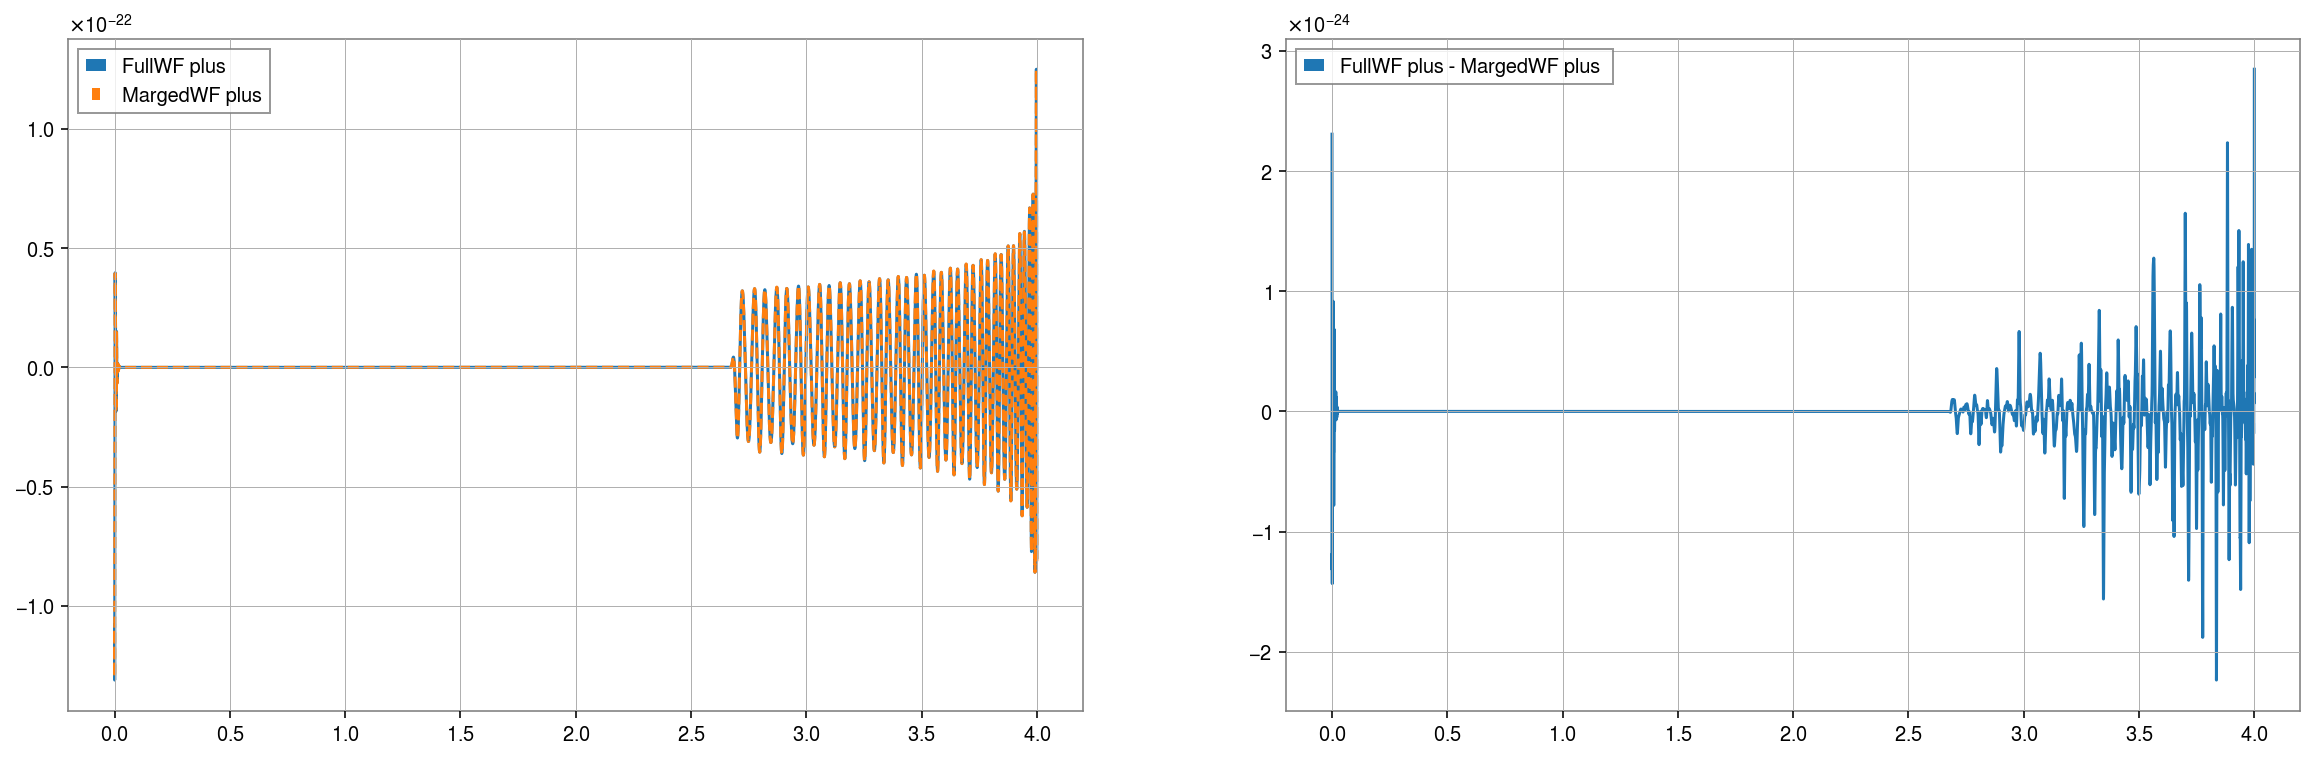

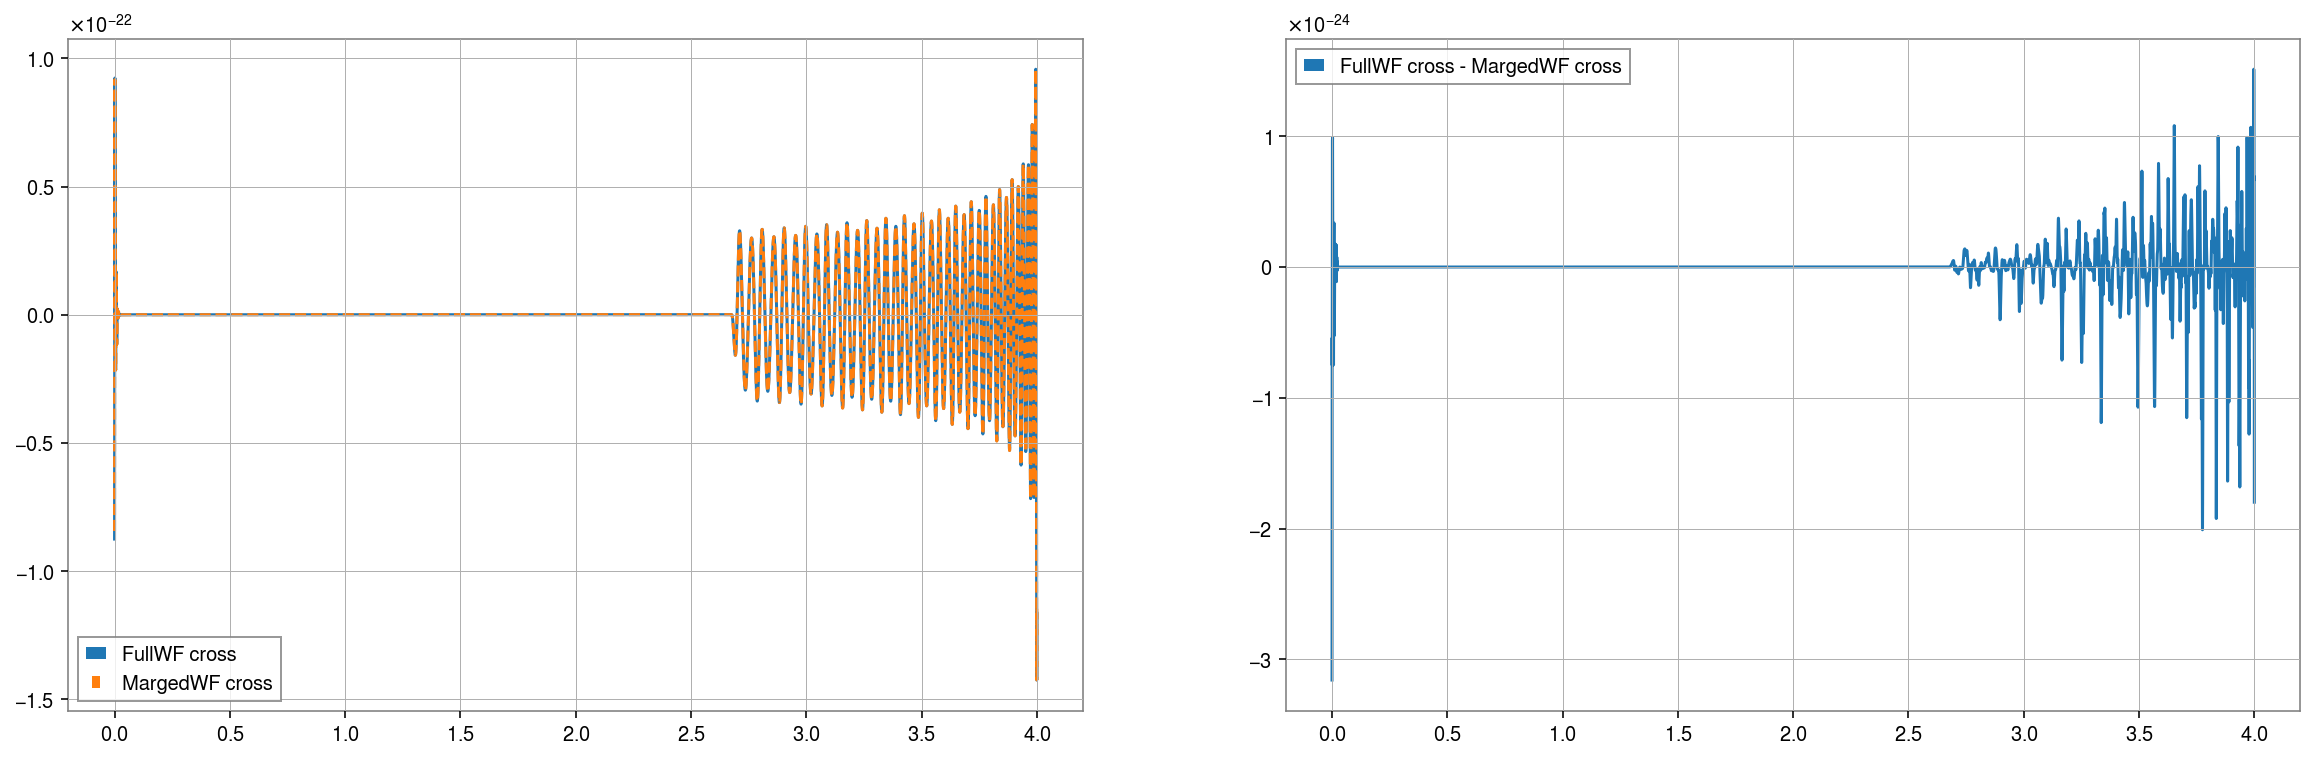

In [218]:
random_WF_index = np.random.randint(0, N_WFs)

print(random_WF_index, theta_jn_samples[random_WF_index])

plt.figure(figsize=(20,10/1.61803398875))
plt.subplot(121)
plt.plot(times, Full_WFs[random_WF_index].real, label='FullWF plus')
plt.plot(times, Marged_WFs[random_WF_index].real, label='MargedWF plus', ls='--')
plt.legend()
plt.subplot(122)
plt.plot(times, Full_WFs[random_WF_index].real-Marged_WFs[random_WF_index].real, label='FullWF plus - MargedWF plus ')
plt.legend()
plt.show()

plt.figure(figsize=(20,10/1.61803398875))
plt.subplot(121)
plt.plot(times, -Full_WFs[random_WF_index].imag, label='FullWF cross')
plt.plot(times, -Marged_WFs[random_WF_index].imag, label='MargedWF cross', ls='--')
plt.legend()
plt.subplot(122)
plt.plot(times, -Full_WFs[random_WF_index].imag+Marged_WFs[random_WF_index].imag, label='FullWF cross - MargedWF cross')
plt.legend()
plt.show()

In [185]:
Nextrinsic = 50

IFO_cached = lal.CachedDetectors[lal.LALDetectorIndexLHODIFF]
gmst = lal.GreenwichMeanSiderealTime(1135136350.64)

Aplus_match = np.zeros([N_WFs, Nextrinsic])
Flat_match = np.zeros([N_WFs, Nextrinsic])


In [186]:
sampling_freq = 1/(times[1]-times[0])
minimum_freq = 20.

for i in tqdm(range(N_WFs)):
    
    Psi_samples = uniform_in_angle(Nextrinsic,theta_max=np.pi)

    RA_samples = uniform_in_angle(Nextrinsic)
    dec_samples = uniform_in_cos_angle(Nextrinsic,offset=-np.pi/2.)
    
    Full_WFplus_FFT, Full_WF_freq = nfft(Full_WFs[i].real, sampling_frequency=sampling_freq)
    Full_WFcross_FFT, Full_WF_freq = nfft(-Full_WFs[i].imag, sampling_frequency=sampling_freq)
    Marged_WFplus_FFT, Marged_WF_freq = nfft(Marged_WFs[i].real, sampling_frequency=sampling_freq)
    Marged_WFcross_FFT, Marged_WF_freq = nfft(-Marged_WFs[i].imag, sampling_frequency=sampling_freq)
    
    goodFreq_pick = np.logical_and(np.greater_equal(Full_WF_freq, minimum_freq), np.less(Full_WF_freq, sampling_freq/2))
    
    Aplus_PSD = np.interp(Full_WF_freq[goodFreq_pick], Aplus_asd[:,0], np.square(Aplus_asd[:,1]), left=1., right=1.)
    Flat_PSD = np.ones_like(Full_WF_freq[goodFreq_pick])*1e-47
    
    for j in range(Nextrinsic):
        
        F_plus, F_cross = lal.ComputeDetAMResponse(IFO_cached.response, RA_samples[j], dec_samples[j], Psi_samples[j], gmst)
        
        Full_WF_FFT = F_plus*Full_WFplus_FFT[goodFreq_pick] + F_cross*Full_WFcross_FFT[goodFreq_pick]
        
        Marged_WF_FFT = F_plus*Marged_WFplus_FFT[goodFreq_pick] + F_cross*Marged_WFcross_FFT[goodFreq_pick]
        
        FullFull_Aplus = innprod(Full_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        MargedFull_Aplus = innprod(Marged_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        MargedMarged_Aplus = innprod(Marged_WF_FFT, Marged_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        
        Aplus_match[i,j] = MargedFull_Aplus/np.sqrt(FullFull_Aplus*MargedMarged_Aplus)
        
        FullFull_Flat = innprod(Full_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        MargedFull_Flat = innprod(Marged_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        MargedMarged_Flat = innprod(Marged_WF_FFT, Marged_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        
        Flat_match[i,j] = MargedFull_Flat/np.sqrt(FullFull_Flat*MargedMarged_Flat)

100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


In [196]:
np.argmax(Aplus_match)#.reshape([N_WFs, Nextrinsic])
np.unravel_index(np.argmax(Aplus_match, axis=None), Aplus_match.shape)

(95, 22)

5000 1.0


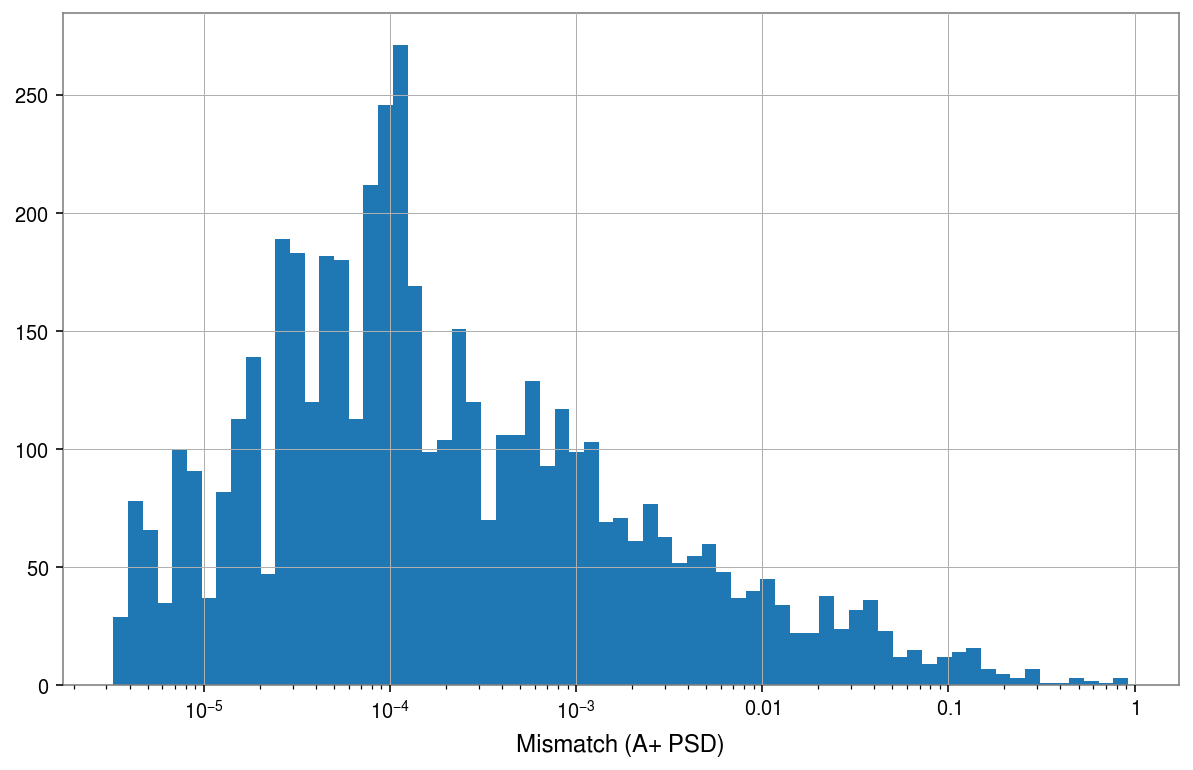

0.923 0.01
0.7644 0.001
0.4364 0.0001


In [187]:
Aplus_hist_pick = np.less(1-Aplus_match.flatten(), 1)
print(Aplus_hist_pick.sum(), Aplus_hist_pick.sum()/(N_WFs*Nextrinsic))

Aplus_hist_bins = np.logspace(np.log10(1-Aplus_match.flatten()[Aplus_hist_pick ]).min(), \
                              np.log10(1-Aplus_match.flatten()[Aplus_hist_pick ]).max(), int(np.sqrt(N_WFs*Nextrinsic)))

plt.figure(figsize=(10,10/1.61803398875))
plt.hist(1-Aplus_match.flatten()[Aplus_hist_pick], bins=Aplus_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.show()
#print(np.log10(1-Flat_matches.flatten()).min())
#print(np.log10(np.array([1, 1-Flat_matches.flatten().min()])))

print(np.less(1-Aplus_match.flatten()[Aplus_hist_pick ], 1e-2).sum()/(N_WFs*Nextrinsic), 1e-2)
print(np.less(1-Aplus_match.flatten()[Aplus_hist_pick ], 1e-3).sum()/(N_WFs*Nextrinsic), 1e-3)
print(np.less(1-Aplus_match.flatten()[Aplus_hist_pick ], 1e-4).sum()/(N_WFs*Nextrinsic), 1e-4)

5000 1.0


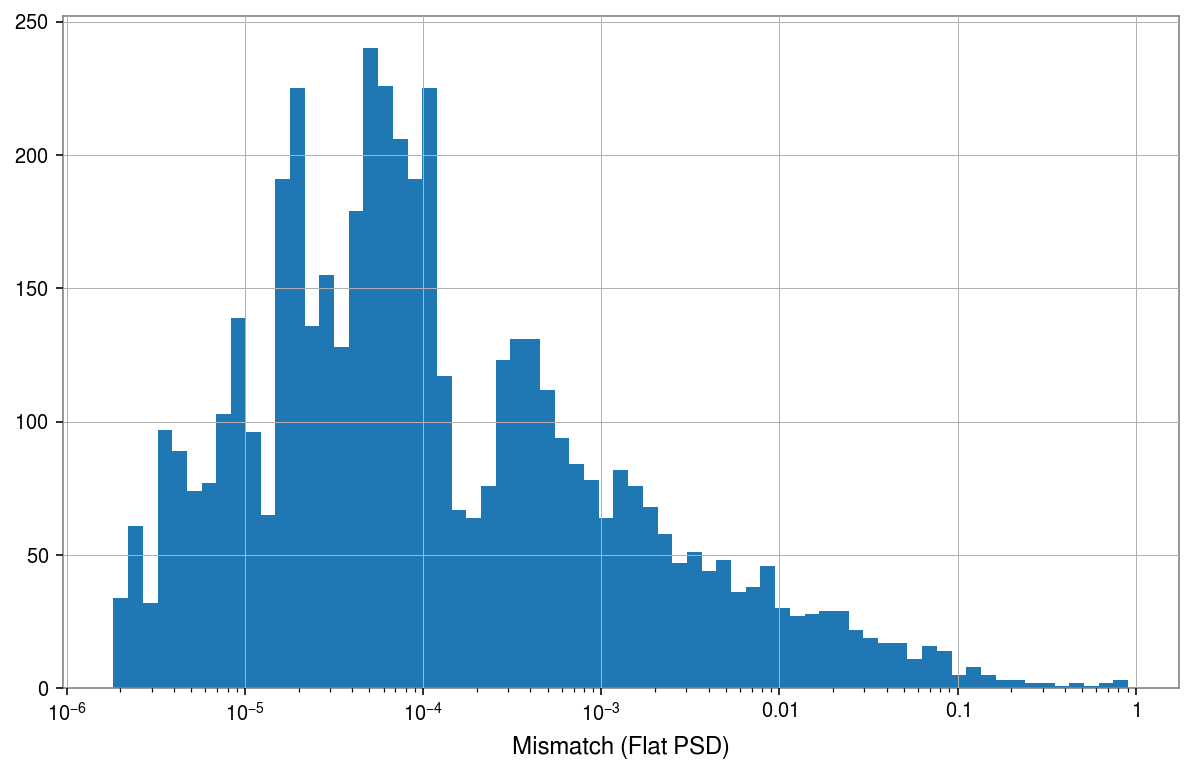

0.9438 0.01
0.8118 0.001
0.5506 0.0001


In [188]:
Flat_hist_pick = np.less(1-Flat_match.flatten(), 1)
print(Flat_hist_pick.sum(), Flat_hist_pick.sum()/(N_WFs*Nextrinsic))

Flat_hist_bins = np.logspace(np.log10(1-Flat_match.flatten()[Flat_hist_pick ]).min(), \
                              np.log10(1-Flat_match.flatten()[Flat_hist_pick ]).max(), int(np.sqrt(N_WFs*Nextrinsic)))

plt.figure(figsize=(10,10/1.61803398875))
plt.hist(1-Flat_match.flatten()[Flat_hist_pick], bins=Flat_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (Flat PSD)')
plt.show()
print(np.less(1-Flat_match.flatten()[Flat_hist_pick ], 1e-2).sum()/(N_WFs*Nextrinsic), 1e-2)
print(np.less(1-Flat_match.flatten()[Flat_hist_pick ], 1e-3).sum()/(N_WFs*Nextrinsic), 1e-3)
print(np.less(1-Flat_match.flatten()[Flat_hist_pick ], 1e-4).sum()/(N_WFs*Nextrinsic), 1e-4)

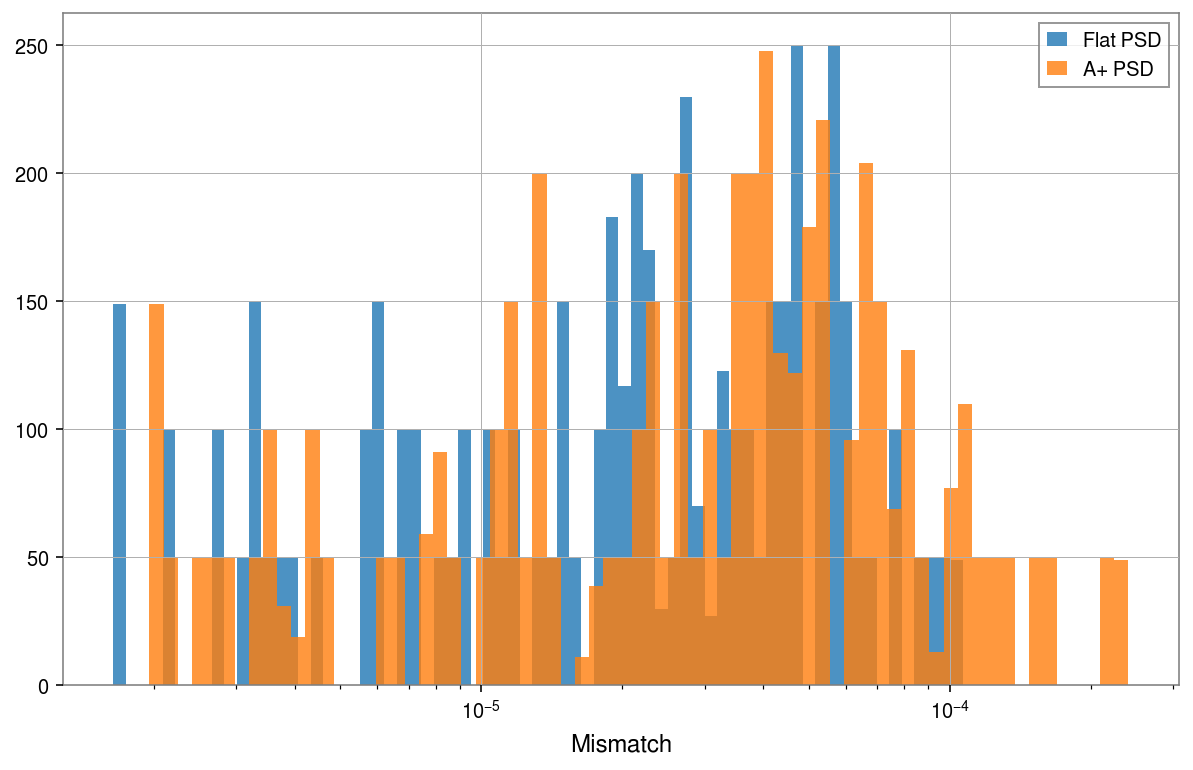

In [177]:
plt.figure(figsize=(10,10/1.61803398875))
plt.hist(1-Flat_match.flatten()[Flat_hist_pick], bins=Flat_hist_bins , alpha=0.8, label='Flat PSD')
plt.hist(1-Aplus_match.flatten()[Aplus_hist_pick], bins=Aplus_hist_bins , alpha=0.8, label='A+ PSD')
plt.legend()
plt.xscale('log')
plt.xlabel('Mismatch')
plt.show()

In [189]:
def simple_mismatch(h, x):
    """ Computes Mismatch without phase and time shift.
    h is Complex target waveform.
    x is Complex template waveform.
    Step size should be constant as we are approximating an intergral by a sum.
    """
    norm_h =  np.sqrt(np.real(np.sum(h*np.conj(h))))
    norm_x =  np.sqrt(np.real(np.sum(x*np.conj(x))))
    overlap = np.abs(np.sum(x*np.conj(h))/norm_h/norm_x)
    return 1 - overlap 

In [190]:
TD_mismatches = np.zeros(N_WFs)

for i in tqdm(range(N_WFs)):
    TD_mismatches[i] = simple_mismatch(Full_WFs[i], Marged_WFs[i])

100%|██████████| 100/100 [00:00<00:00, 1515.79it/s]


100 1.0


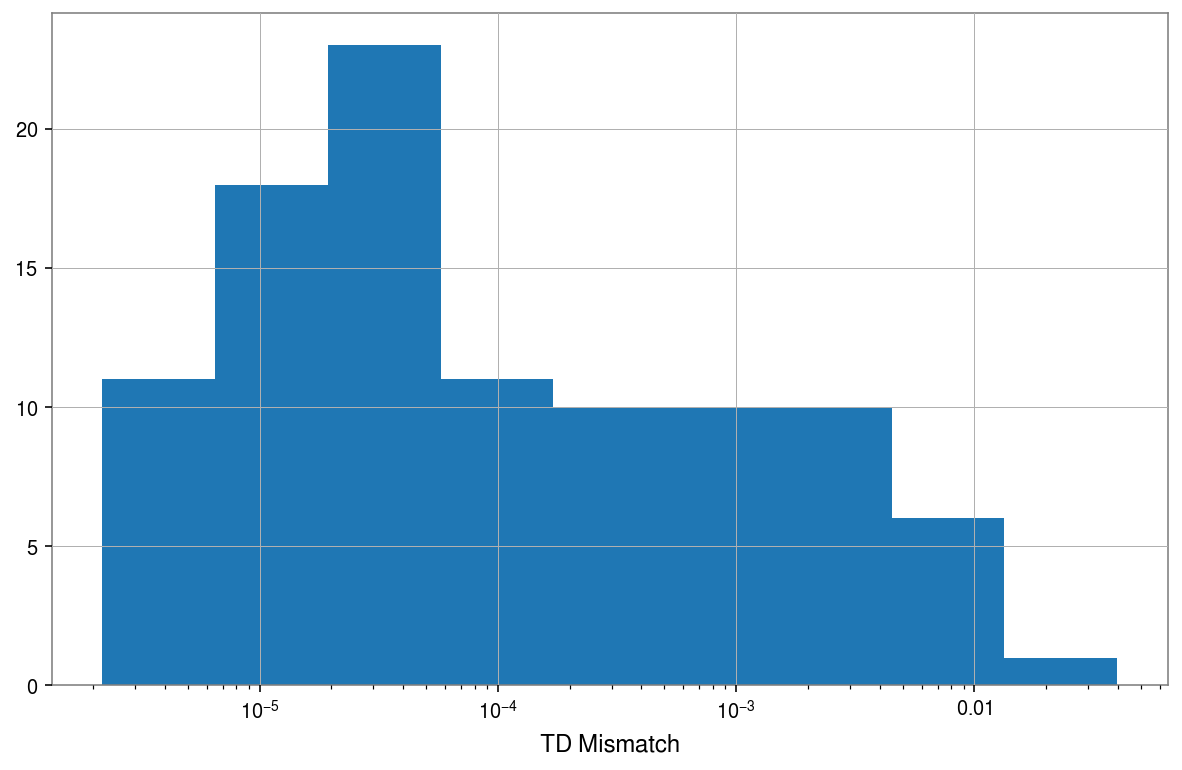

In [191]:
TD_hist_pick = np.less(TD_mismatches, 1)
print(TD_hist_pick.sum(), TD_hist_pick.sum()/(N_WFs))

TD_hist_bins = np.logspace(np.log10(TD_mismatches[TD_hist_pick ]).min(), \
                              np.log10(TD_mismatches[TD_hist_pick ]).max(), int(np.sqrt(N_WFs)))

plt.figure(figsize=(10,10/1.61803398875))
plt.hist(TD_mismatches[TD_hist_pick], bins=TD_hist_bins )
plt.xscale('log')
plt.xlabel('TD Mismatch')
plt.show()